# Introduction

It's common for data practitioners to quickly hit the limtiations of Pandas. Pandas is single-core and creates a lot of [intermediate copies](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html#scaling-to-large-datasets) of data that increase memory usage. Even if the Pandas engine is improving, it's still not optimal to use when data size is beyond a few GBs.

At this point, the advice is normally to scale Pandas using Dask (or Spark with PySpark Pandas formerly known as Koalas). This assumes users have clusters that they can port their workload to, but in smaller organizations, it may be hard to obtain such resources.

This notebook/blog looks into optimizing the experience on a single by machine by developing using DuckDB and Pandas side-by-side through Fugue. DuckDB is an in-memory OLAP database that is faster than SQLLite for most data workflows because SQLLite is optimized to handle transacitons rather than aggregatations (OLTP). More information can be found on the DuckDB website [here](https://duckdb.org/). Fugue on the other hand, is an abstraction layer that ports SQL, Pandas, and native Python code to Spark and Dask. It provides the tools to seamlessly work with SQL and Pandas interactivately. For example, it adds other keywords such as `LOAD` and `SAVE` that allow working with files, and `TRANSFORM` to invoke Python functions as we'll see in this article.

When data in a database is too big, it's common for data scientists to aggregate it and bring it out for further analysis in Pandas. For example, timeseries data that is second-level can be aggregated to minute-level to reduce the data by a factor of 60. By using this stack of tools, we will we able to use DuckDB to quickly process data and use Pandas for more complicated transformations to quickly prototype our workflow. Once we are ready, we can bring the execution to Spark to scale out if we have a cluster.

# Setup

First we import some setup functions for Fugue. This will let us use the `%%fsql` cell magic inside Jupyter notebooks. We'll also import the `duckdb` engine to use it with Fugue. 

In [1]:
from fugue_notebook import setup
import fugue_duckdb

setup()

<IPython.core.display.Javascript object>

## Other Imports

In [2]:
import os
import glob
import pandas as pd

from fugue_sql import fsql

# Data

This notebook will use the Binance Crypto Kittens dataset. This can be downloaded from [Kaggle](https://www.kaggle.com/binance/binance-crypto-klines) available through the Creative Commons License. We will unzip this and save this in a folder called `crypto-binance` alongside our code.

It is over 1000 distinct files and totals over 5GB. The files are partitioned by month-year.

In [3]:
os.listdir("crypto-binance")

['.DS_Store', '01-2018', '11-2017', '12-2017', '02-2018', '03-2018']

Going into one of these folders, we can take a look at the files inside.

In [4]:
os.listdir("crypto-binance/01-2018/01-2018")[0:10]

['RDNETH.csv',
 'LSKBTC.csv',
 'ICXBNB.csv',
 'POEETH.csv',
 'EDOETH.csv',
 'GTOBNB.csv',
 'MANAETH.csv',
 'VIBETH.csv',
 'ZECETH.csv',
 'TRXETH.csv']

We can see the schema by reading one of them. No need to understand what the columns are if they are not familiar. The point is that we have over 1000 files that have the same schema.

In [5]:
df = pd.read_csv("crypto-binance/01-2018/01-2018/RDNETH.csv")
df.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume
0,1514764800000,0.005738,0.005738,0.005738,0.005738,6.0,1514764859999,0.034430,1,0.0,0.00000
1,1514764860000,0.005738,0.005738,0.005738,0.005738,0.0,1514764919999,0.000000,0,0.0,0.00000
2,1514764920000,0.005804,0.005804,0.005738,0.005778,861.0,1514764979999,4.976309,12,545.0,3.16295
3,1514764980000,0.005803,0.005803,0.005803,0.005803,271.0,1514765039999,1.572640,1,271.0,1.57264
4,1514765040000,0.005778,0.005803,0.005778,0.005778,1360.0,1514765099999,7.865015,5,271.0,1.57264


It's not practical to work with these files individually so we need to combine them. The problem is then that we can't distinguish the contents of each file because the identifier of the data is the filename. We'll start by combining these files, adding the filename as a column, and then saving it out.

# Preprocessing

For the bigger file, we will use the parquet file format because it is roughly 20% the size of CSV, holds schema, and is a column-based storage so it can optimize data access. Parquet tends to be better than CSVs, especially for big data.

We have two approaches we can use to combine all of the small files into a bigger file. The first is using Pandas. The standard way is to append all the small DataFrames into a list, and then use `pd.concat` to combine all of them.

## Using Pandas

We'll see that this operation takes 1 minute and 15 seconds.

In [6]:
%%time
def process_files_pandas():
    filenames = glob.glob("crypto-binance/*/*/" + "*.csv")
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename)
        df['symbol'] = filename.split('/')[-1].split('.')[0]
        df['time'] = pd.to_datetime(df['Open_time'], unit='ms')
        df = df.drop(['Open_time'], axis=1)
        dfs.append(df)

    # Concatenate all data into one DataFrame
    big_frame = pd.concat(dfs, ignore_index=True)
    big_frame.to_parquet("/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet")
    
process_files_pandas()

CPU times: user 1min 8s, sys: 16.3 s, total: 1min 24s
Wall time: 1min 37s


## DuckDB

Now, we can trying using DuckDB to perform the operation. The `%%fsql duck` lets us use DuckDB as a backend through FugueSQL. `LOAD`, `SAVE`, and `DROP COLUMNS` are FugueSQL keywords that get converted to the equivalent DuckDB code. It also accepts the keyword arguments that DuckDB can take when reading files. In this case, we are using the `FILENAME` keyword to add a new column that contains the filename.

In [7]:
%%fsql duck
LOAD "crypto-binance/*/*/*.csv"(header=true,infer_schema=true, FILENAME=1)
SELECT epoch_ms(Open_time) AS time, string_split(string_split(filename, '/')[-1],'.')[0] AS symbol,*
DROP COLUMNS Open_time, filename
SAVE OVERWRITE "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"

We can't use `%%time` with the `%%fsql` cell magic so we need to wrap the query and pass it to `fsql` instead, which is what the `%%fsql` operator does under the hood. By timing the operation, we actually see that Pandas was faster. DuckDB takes around 4 minutes and 20 seconds to perform the same operation. In reality, this is a one-time preprocessing step so it's better to just use whatever tool allows the user to achieve it faster.

In [8]:
%%time
query = """
        LOAD "crypto-binance/*/*/*.csv"(header=true,infer_schema=true, FILENAME=1)
        SELECT epoch_ms(Open_time) AS time, string_split(string_split(filename, '/')[-1],'.')[0] AS symbol,*
        DROP COLUMNS Open_time, filename
        SAVE OVERWRITE "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"
        """
# For Khuyen, I commented this line so we don't re-run the query above because it takes 4 mins.
# fsql(query).run("duckdb")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


To test that the transformation was successful, we can open the file and `PRINT` a few rows. 

In [9]:
%%time
query = """
LOAD "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"
PRINT
"""
fsql(query).run("duckdb")

,time,symbol,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume
0,2018-01-01 00:00:00,RDNETH,0.005738,0.005738,0.005738,0.005738,6.0,1514764859999,0.034430,1,0.0,0.000000
1,2018-01-01 00:01:00,RDNETH,0.005738,0.005738,0.005738,0.005738,0.0,1514764919999,0.000000,0,0.0,0.000000
2,2018-01-01 00:02:00,RDNETH,0.005804,0.005804,0.005738,0.005778,861.0,1514764979999,4.976309,12,545.0,3.162950
3,2018-01-01 00:03:00,RDNETH,0.005803,0.005803,0.005803,0.005803,271.0,1514765039999,1.572640,1,271.0,1.572640
4,2018-01-01 00:04:00,RDNETH,0.005778,0.005803,0.005778,0.005778,1360.0,1514765099999,7.865015,5,271.0,1.572640
5,2018-01-01 00:05:00,RDNETH,0.005800,0.005800,0.005778,0.005778,687.0,1514765159999,3.973886,3,0.0,0.000000
6,2018-01-01 00:06:00,RDNETH,0.005778,0.005778,0.005753,0.005753,1730.0,1514765219999,9.994557,7,53.0,0.304925
7,2018-01-01 00:07:00,RDNETH,0.005753,0.005753,0.005703,0.005744,1290.0,1514765279999,7.380107,14,631.0,3.620001
8,2018-01-01 00:08:00,RDNETH,0.005743,0.005750,0.005743,0.005750,197.0,1514765339999,1.131479,6,197.0,1.131479
9,2018-01-01 00:09:00,RDNETH,0.005750,0.005750,0.005750,0.005750,0.0,1514765399999,0.000000,0,0.0,0.000000


CPU times: user 57.9 ms, sys: 16 ms, total: 73.9 ms
Wall time: 156 ms


DataFrames()

This executes in 200 ms. If you remove `"duckdb"` and use the default Pandas-based engine, it will take around 25 seconds. Why is `duckdb` so much faster? This is because it uses lazy evaluation. The `PRINT` statement returns a default of 10 records. `duckdb` will know that only 10 records are needed by the end result, so it only fetches those records. On the other hand, Pandas is executed eagerly, meaning the entire file is loaded in and then the operation to fetch the first 10 rows isran.

This point is important in thinking about the use cases where `duckdb` can be the preferred engine. We can perform filters and fetch only the data we need before bringing it to Pandas to limit the data transfer and speed up execution time.

## Processing

The data we started with is now compressed into a parquet file. We can load from this directly. Again, using DuckDB's lazy evaluation, we can apply filters and aggregates before we bring the data to Python. The query below executes in a few seconds (nowhere near the 20+ it takes for Pandas to load). From here on out, we will be less concerned with execution time because `duckdb` will be significantly faster for a lot of operations.

In [10]:
%%fsql duck
LOAD "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"
SELECT * WHERE symbol LIKE '%USDT'
SELECT symbol, date_trunc('day',time) AS date, SUM(Number_of_trades) AS trades GROUP BY 1,2
SELECT symbol, AVG(trades) AS trades GROUP BY 1 ORDER BY 2 DESC LIMIT 3
YIELD DATAFRAME AS top_symbols
PRINT

,symbol,trades
0,BTCUSDT,204608.145695
1,ETHUSDT,121244.543046
2,LTCUSDT,50804.761468


For people familiar with SQL, it may be confusing that there are multiple `SELECT` statements. FugueSQL allows for multiple `SELECT` statements similar to SQL temp tables. This allows the code to be read top-down and eliminates a for of boilerplate code. If `FROM` is not specified, the SQL statement uses the last DataFrame from the stack. So in order this previous code:

1. Loads the file
2. Filters for the entries there the symbol contains USDT
3. Sums the number of trades grouped by symbol and date
4. Gets the average daily trades for each symbol and gets the 3 most traded
5. Uses the YIELD keyword to output this as a Python DataFrame

For those that prefer explicit variable assignment, the syntax below is also accepted.

```
df = LOAD "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"
df2 = SELECT * FROM df WHERE symbol LIKE '%USDT'
SELECT symbol, date_trunc('day',time) AS date, SUM(Number_of_trades) AS trades FROM df2 GROUP BY 1,2
```

and so on. Using the previous Dataframe in the stack automatically is called [anonimity](https://fugue-tutorials.readthedocs.io/tutorials/fugue_sql/syntax.html#anonymity), and can be mixed and matched with the variable assignment syntax.

## Using a YIELDED DataFrame

FugueSQL uses the YIELD keyword to output a DataFrame to be used in a future FugueSQL query or in Python. Multiple DataFrames can be YIELDED in a query. By using `as_pandas()`, we can bring convert `top_symbols` to Pandas, and then use Pandas operations on it such as `head()`.

In [11]:
top_symbols.as_pandas().head()

,symbol,trades
0,BTCUSDT,204608.145695
1,ETHUSDT,121244.543046
2,LTCUSDT,50804.761468


We can also use the YIELDED `top_symbols` dataframe in following FugueSQL code blocks as well. Now that we know the most traded symbols, we can filter for them from the original file by doing an inner join. Again, because of the lazy evaluation, this returns a much smaller dataset than the original when it is brought to Python.

Notice in this case we use the variable assignment syntax. This is because we need to specify table names when we `JOIN`

In [12]:
%%fsql duck
src = LOAD "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"
SELECT src.* FROM src INNER JOIN top_symbols ON src.symbol = top_symbols.symbol
YIELD DATAFRAME AS top_data

## Using a Python extension - OUTPUT

One of the strengths of using Fugue and DuckDB together is the ability to add Python logic through extensions. These extensions can then be invoked by SQL code. For example, we create a plotting function.

In [13]:
def plot_by(df:pd.DataFrame, by, y) -> None:
    for name, group in df.groupby(by):
        group.plot(x="time", y=y, title=name)

Now we can use this function by using the FugueSQL `OUTPUT` keyword. This will bring the data from `DuckDB` to Python and execute the `plot_by` function.

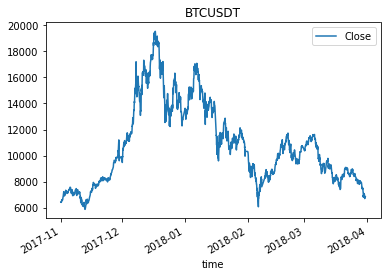

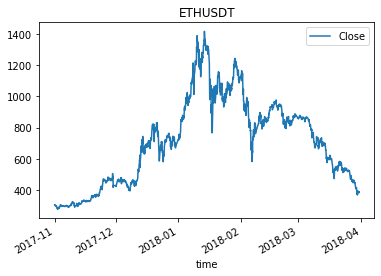

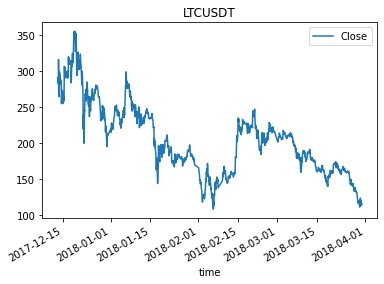

In [14]:
%%fsql duck
SELECT * FROM top_data
SAMPLE 1 PERCENT SEED 0
SELECT * ORDER BY time
OUTPUT USING plot_by(by="symbol", y="Close")

## Using a Python extension - TRANSFORM

In the next example, we want to use the `pandas_ta` library to do some technical analysis on the timeseries data. We create a function that will create an `macd` column so that we can invoke it in Python later. The `macd` is an indicator of the trend of the timeseries. This is a normal Python function with the schema hint as a comment. Fugue can read this schema hint and apply the schema, which is a requirement for distributed backends such as Spark and Dask.

In [15]:
# schema: *,macd:double
def macd(df:pd.DataFrame) -> pd.DataFrame:
    import pandas_ta
    macd = df.ta.macd(close='close', fast=12, slow=26, signal=9)
    return df.assign(macd=macd.iloc[:,2])

We'll invoke this function in the end-to-end workflow.

# Parameterizing

We now have components of a pipeline we can put together. We can parameterize the SQL code by using Jinja templating. This allows us to easily look process other symbols we are interested in. We'll just use the top 2 symbols for now.

In [16]:
path = "/Users/kevinkho/work/demos/blogs/fugue-duckdb/raw.parquet"
symbol_pattern = "%USDT"
top_n = 2

In order, the pipeline below does the following:

1. Load the file and get the top traded symbols
2. Do an inner join to just retain the top traded symbols
3. Perform aggregates on the day level
4. Use the macd function we defined earlier
5. Plot the macd plots

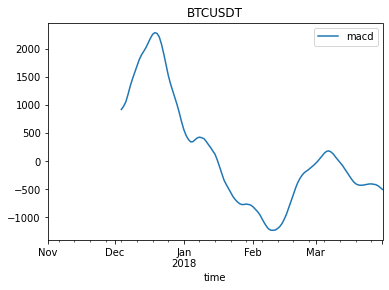

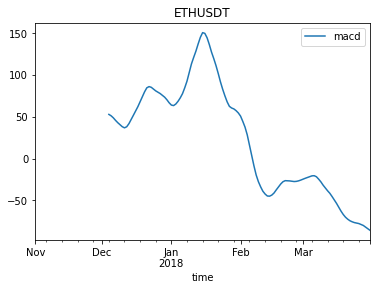

In [17]:
%%fsql duck
src = LOAD "{{path}}"
SELECT * WHERE symbol LIKE '{{symbol_pattern}}'
SELECT symbol, date_trunc('day',time) AS date, SUM(Number_of_trades) AS trades GROUP BY 1,2
top_symbols = SELECT symbol, AVG(trades) AS trades GROUP BY 1 ORDER BY 2 DESC LIMIT {{top_n}}

SELECT src.* FROM src INNER JOIN top_symbols ON src.symbol = top_symbols.symbol

SELECT
    symbol,
    date_trunc('day', time) AS time,
    min_by(Open, time) AS open,
    MAX(High) AS high,
    MIN(Low) AS low,
    max_by(Close, time) AS close,
    SUM(Number_of_trades) AS trades,
    SUM(Volume) AS volume
GROUP BY 1, 2

TRANSFORM PREPARTITION BY symbol PRESORT time
USING macd

SELECT * ORDER BY time
OUTPUT USING plot_by(by='symbol', y="macd")

Again, this workflow executes in a few seconds because of the lazy evaluation and speed we get from DuckDB. One the data is filtered and aggregated, we can bring the result into Pandas. This means the initial dataset does not even have to fit in-memory (although DuckDB has limits to how much it can handle out of RAM). 

# Executing on Spark

After prototyping on a smaller dataset, we execute the pipeline on a larger dataset. Wouldn't it be great if we could change the backend to Spark and run everything? Well with Fugue we can change the execution engine and in this case, it will work without any changes because the SparkSQL API and DuckDB API are very similar. The execution of the code below will take a bit longer because of spinning up the Spark session, but it will be scalable over a cluster using Spark.

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/20 22:37:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrames()

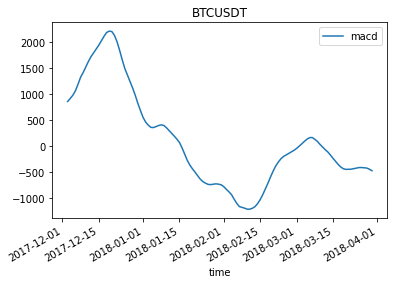

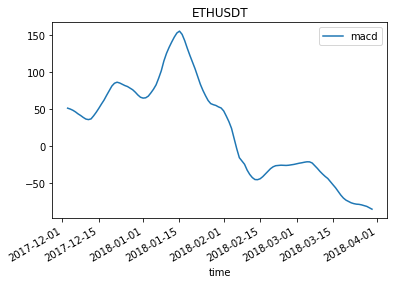

In [18]:
import fugue_spark
query = """ src = LOAD "{{path}}"
            SELECT * WHERE symbol LIKE '{{symbol_pattern}}'
            SELECT symbol, date_trunc('day',time) AS date, SUM(Number_of_trades) AS trades GROUP BY 1,2
            top_symbols = SELECT symbol, AVG(trades) AS trades GROUP BY 1 ORDER BY 2 DESC LIMIT {{top_n}}
            
            SELECT src.* FROM src INNER JOIN top_symbols ON src.symbol = top_symbols.symbol

            SELECT
                symbol,
                date_trunc('day', time) AS time,
                min_by(Open, time) AS open,
                MAX(High) AS high,
                MIN(Low) AS low,
                max_by(Close, time) AS close,
                SUM(Number_of_trades) AS trades,
                SUM(Volume) AS volume
            GROUP BY 1, 2

            TRANSFORM PREPARTITION BY symbol PRESORT time
            USING macd

            SELECT * ORDER BY time
            OUTPUT USING plot_by(by='symbol', y="macd")
            """
fsql(query).run("spark")

# Conclusion

In this article, we went over using FugueSQL with DuckDB and Pandas as backends to get the most out of local execution. Because of the lazy evaluation DuckDB provides, we can pre-aggregate our data quickly before bringing it to Pandas for further analyis that is hard to do in SQL. Using FugueSQL as the interface to build this workflow allows us to use the strengths of each backend seamlessly.

As a bonus, the same code is parameterizeable and will execute on Spark. In the event that we need to scale execution to a cluster on big data, we can just change the backend and have Fugue be responsible for porting the code over.